<a id="0"></a>  
 
### Índice:
#### 1. [Recopilación de tweets](#1)  
#### 2. [AWS Conexión con DB](#2)  
#### 3. [Análisis de datos](#3)  
#### 4. [Machine Learning](#4)  
#### 5. [Conclusiones finales](#5)  

<a id="1"></a> <br>
### 1. - Recopilación de tweets.

Debido a que tuve muchos problemas ya que no terminaba de hacer funcionar la API y hacer scrapping es ahora gracias al bueno de Elon bastante complicado. Me fije en el Endpoint subido por el propio Elon...

Primero importamos todas las librerias necesarias en nuestro problema.

In [139]:
import requests
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from spacy.lang.es.stop_words import STOP_WORDS
import pymysql
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

In [92]:
timestamp = datetime.datetime.now().strftime('%Y-%m-%d%H:%M:%S')
params = {'ts': timestamp};
url = "http://twitterdata-env-1.eba-znn3kr4u.us-east-2.elasticbeanstalk.com/get_data?year=2022"
res = requests.get(url,params=params)
res

<Response [200]>

In [93]:
json_2022 = res.json()

In [94]:
timestamp = datetime.datetime.now().strftime('%Y-%m-%d%H:%M:%S')
params = {'ts': timestamp, 
        'limit': 100};
url = "http://twitterdata-env-1.eba-znn3kr4u.us-east-2.elasticbeanstalk.com/get_data?year=2023"
res = requests.get(url,params=params)
res

<Response [200]>

In [95]:
json_2023 = res.json()

Hacemos dos dataframes de cada año y posteriormente los concatenamos

In [96]:
data_list_2022 = json_2022['data']
data_list_2023 = json_2023['data']
df_2022 = pd.DataFrame(data_list_2022)
df_2023 = pd.DataFrame(data_list_2023)

In [97]:
df_2022.head()

,author_id,created_at,edit_history_tweet_ids,id,public_metrics,text
0,1151510939105144834,2022-12-29T16:39:19.000Z,[1608502937332113408],1608502937332113408,"{'impression_count': 113, 'like_count': 4, 'qu...",Empieza el año formándote en una de las profes...
1,570795448,2022-12-29T12:52:11.000Z,[1608445776732246017],1608445776732246017,"{'impression_count': 124, 'like_count': 2, 'qu...",Los 4 bootcamps tecnológicos de EDEM y @TheBri...
2,1128860148,2022-12-29T09:16:11.000Z,[1608391421014196224],1608391421014196224,"{'impression_count': 49, 'like_count': 2, 'quo...",@EDEMempresarios acoge el 12 de enero un Open ...
3,570795448,2022-12-27T09:00:57.000Z,[1607662809575292929],1607662809575292929,"{'impression_count': 218, 'like_count': 5, 'qu...",Si estás buscando una profesión que te cambie ...
4,1162694149956603904,2022-12-23T12:54:06.000Z,[1606271930763354112],1606271930763354112,"{'impression_count': 120, 'like_count': 1, 'qu...",En @TheBridge_Tech tenemos un deseo para ti💫\n...


In [98]:
df_2023.head()

,author_id,created_at,edit_history_tweet_ids,id,public_metrics,text
0,936539844079218688,2023-03-07T17:16:14.000Z,[1633154604018876416],1633154604018876416,"{'impression_count': 357, 'like_count': 8, 'qu...",¡Hola #dataholics! La primavera trompetera se ...
1,1585726199485140993,2023-03-06T10:38:30.000Z,[1632692123412594688],1632692123412594688,"{'impression_count': 31, 'like_count': 0, 'quo...",Las inscripciones se realizarán por Eventbrite...
2,1585726199485140993,2023-03-06T10:38:30.000Z,[1632692120719859712],1632692120719859712,"{'impression_count': 950, 'like_count': 5, 'qu...",¡Por fin podemos publicar el cartel con los po...
3,41545659,2023-03-06T08:48:56.000Z,[1632664546665025536],1632664546665025536,"{'impression_count': 90, 'like_count': 3, 'quo...","Encuentro de la @mlopscommunity en Madrid: ""ML..."
4,925597948410580993,2023-03-04T22:32:56.000Z,[1632147141224275970],1632147141224275970,"{'impression_count': 35, 'like_count': 1, 'quo...",@nodosenlared @snowded @TheBridge_Tech Muy bue...


In [99]:
df_2022.public_metrics.head()

0    {'impression_count': 113, 'like_count': 4, 'qu...
1    {'impression_count': 124, 'like_count': 2, 'qu...
2    {'impression_count': 49, 'like_count': 2, 'quo...
3    {'impression_count': 218, 'like_count': 5, 'qu...
4    {'impression_count': 120, 'like_count': 1, 'qu...
Name: public_metrics, dtype: object

Esta columna esta como diccionario asique sacamos la información de ahí.


In [100]:
df_norm_2022 = pd.json_normalize(df_2022['public_metrics'])
df_norm_2023 = pd.json_normalize(df_2023['public_metrics'])
df_2022 = result_df = pd.concat([df_2022, df_norm_2022], axis=1)
df_2023 = result_df = pd.concat([df_2023, df_norm_2023], axis=1)

In [101]:
df_2022.head()

,author_id,created_at,edit_history_tweet_ids,id,public_metrics,text,impression_count,like_count,quote_count,reply_count,retweet_count
0,1151510939105144834,2022-12-29T16:39:19.000Z,[1608502937332113408],1608502937332113408,"{'impression_count': 113, 'like_count': 4, 'qu...",Empieza el año formándote en una de las profes...,113,4,0,0,1
1,570795448,2022-12-29T12:52:11.000Z,[1608445776732246017],1608445776732246017,"{'impression_count': 124, 'like_count': 2, 'qu...",Los 4 bootcamps tecnológicos de EDEM y @TheBri...,124,2,0,0,0
2,1128860148,2022-12-29T09:16:11.000Z,[1608391421014196224],1608391421014196224,"{'impression_count': 49, 'like_count': 2, 'quo...",@EDEMempresarios acoge el 12 de enero un Open ...,49,2,0,0,0
3,570795448,2022-12-27T09:00:57.000Z,[1607662809575292929],1607662809575292929,"{'impression_count': 218, 'like_count': 5, 'qu...",Si estás buscando una profesión que te cambie ...,218,5,0,0,0
4,1162694149956603904,2022-12-23T12:54:06.000Z,[1606271930763354112],1606271930763354112,"{'impression_count': 120, 'like_count': 1, 'qu...",En @TheBridge_Tech tenemos un deseo para ti💫\n...,120,1,0,0,1


Ahora concatenamos los dos df

In [102]:
df_unido = pd.concat([df_2022, df_2023],ignore_index=True)

In [103]:
df_unido

,author_id,created_at,edit_history_tweet_ids,id,public_metrics,text,impression_count,like_count,quote_count,reply_count,retweet_count
0,1151510939105144834,2022-12-29T16:39:19.000Z,[1608502937332113408],1608502937332113408,"{'impression_count': 113, 'like_count': 4, 'qu...",Empieza el año formándote en una de las profes...,113,4,0,0,1
1,570795448,2022-12-29T12:52:11.000Z,[1608445776732246017],1608445776732246017,"{'impression_count': 124, 'like_count': 2, 'qu...",Los 4 bootcamps tecnológicos de EDEM y @TheBri...,124,2,0,0,0
2,1128860148,2022-12-29T09:16:11.000Z,[1608391421014196224],1608391421014196224,"{'impression_count': 49, 'like_count': 2, 'quo...",@EDEMempresarios acoge el 12 de enero un Open ...,49,2,0,0,0
3,570795448,2022-12-27T09:00:57.000Z,[1607662809575292929],1607662809575292929,"{'impression_count': 218, 'like_count': 5, 'qu...",Si estás buscando una profesión que te cambie ...,218,5,0,0,0
4,1162694149956603904,2022-12-23T12:54:06.000Z,[1606271930763354112],1606271930763354112,"{'impression_count': 120, 'like_count': 1, 'qu...",En @TheBridge_Tech tenemos un deseo para ti💫\n...,120,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
144,271028835,2023-01-07T19:55:52.000Z,[1611813891322908672],1611813891322908672,"{'impression_count': 166, 'like_count': 7, 'qu...",🚀 @EDEMempresarios y @TheBridge_Tech se alía...,166,7,0,0,2
145,1530194743786881024,2023-01-06T12:28:27.000Z,[1611338908196913153],1611338908196913153,"{'impression_count': 51, 'like_count': 2, 'quo...",Gracias a nuestros amigos @TheBridge_Tech por ...,51,2,0,0,0
146,10279282,2023-01-04T15:02:11.000Z,[1610652818234347521],1610652818234347521,"{'impression_count': 82, 'like_count': 3, 'quo...",¿Te interesa el diseño de #producto digital? V...,82,3,0,0,2
147,2402179123,2023-01-04T11:57:41.000Z,[1610606391445815297],1610606391445815297,"{'impression_count': 116, 'like_count': 3, 'qu...",¡Empezamos el año con una #masterclass de #uxu...,116,3,0,0,2


Voy a cambiar las fechas y ponerlas con día,mes y año por separado.

In [104]:
df_unido['created_at'] = pd.to_datetime(df_unido['created_at'], errors='coerce')
df_unido['dia'] = df_unido['created_at'].dt.day
df_unido['mes'] = df_unido['created_at'].dt.month
df_unido['año'] = df_unido['created_at'].dt.year

In [105]:
df_unido.head()

,author_id,created_at,edit_history_tweet_ids,id,public_metrics,text,impression_count,like_count,quote_count,reply_count,retweet_count,dia,mes,año
0,1151510939105144834,2022-12-29 16:39:19+00:00,[1608502937332113408],1608502937332113408,"{'impression_count': 113, 'like_count': 4, 'qu...",Empieza el año formándote en una de las profes...,113,4,0,0,1,29,12,2022
1,570795448,2022-12-29 12:52:11+00:00,[1608445776732246017],1608445776732246017,"{'impression_count': 124, 'like_count': 2, 'qu...",Los 4 bootcamps tecnológicos de EDEM y @TheBri...,124,2,0,0,0,29,12,2022
2,1128860148,2022-12-29 09:16:11+00:00,[1608391421014196224],1608391421014196224,"{'impression_count': 49, 'like_count': 2, 'quo...",@EDEMempresarios acoge el 12 de enero un Open ...,49,2,0,0,0,29,12,2022
3,570795448,2022-12-27 09:00:57+00:00,[1607662809575292929],1607662809575292929,"{'impression_count': 218, 'like_count': 5, 'qu...",Si estás buscando una profesión que te cambie ...,218,5,0,0,0,27,12,2022
4,1162694149956603904,2022-12-23 12:54:06+00:00,[1606271930763354112],1606271930763354112,"{'impression_count': 120, 'like_count': 1, 'qu...",En @TheBridge_Tech tenemos un deseo para ti💫\n...,120,1,0,0,1,23,12,2022


In [106]:
df_unido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   author_id               149 non-null    object             
 1   created_at              149 non-null    datetime64[ns, UTC]
 2   edit_history_tweet_ids  149 non-null    object             
 3   id                      149 non-null    object             
 4   public_metrics          149 non-null    object             
 5   text                    149 non-null    object             
 6   impression_count        149 non-null    int64              
 7   like_count              149 non-null    int64              
 8   quote_count             149 non-null    int64              
 9   reply_count             149 non-null    int64              
 10  retweet_count           149 non-null    int64              
 11  dia                     149 non-null    int32

[Volver al índice](#0)

<a id="2"></a> <br>
### 2. AWS enlace con BD

Listo todo ello, vamos a lanzar la información a un servidor SQL en AWS.

Primero necesitaremos acceder a nuestra base de datos.  
1 . Endpoint/Host  
2 . Usuario  
3 . Contraseña  

In [86]:
username = "admin"
password = "12345678"
host = "database-1.cdchgain8wey.us-west-2.rds.amazonaws.com" 
port = 3306

In [87]:
db = pymysql.connect(host = host,
                     user = username,
                     password = password,
                     cursorclass = pymysql.cursors.DictCursor
)


cursor = db.cursor()

In [ ]:
create_db = '''CREATE DATABASE sent_tweet_TheBridgetech'''
cursor.execute(create_db)

In [66]:
cursor.execute('SHOW DATABASES')
cursor.fetchall()

[{'Database': 'information_schema'},
 {'Database': 'mysql'},
 {'Database': 'performance_schema'},
 {'Database': 'sent_tweet_TheBridgetech'},
 {'Database': 'sys'}]

In [70]:
cursor.connection.commit()
use_db = ''' USE sent_tweet_TheBridgetech'''
cursor.execute(use_db)

0

In [74]:
# Crearemos dos tablas una para recopilar la informacion relativa a los mensajes-usuarios y otra a las reacciones.
create_table = '''
CREATE TABLE usr_msg (
    author_id INTEGER,
    created_at TEXT,
    id INT,
    text INT,
    dia INT,
    mes INT,
    año INT
)
'''
cursor.execute(create_table)

0

In [77]:
# Crearemos la segunda tabla.
create_table_2 = '''
CREATE TABLE react (
    impression_count INT,
    like_count INT,
    quote_count INT,
    reply_count INT,
    retweet_count INT
)
'''
cursor.execute(create_table_2)

0

In [78]:
cursor.execute('SHOW TABLES')
cursor.fetchall()

[{'Tables_in_sent_tweet_TheBridgetech': 'react'},
 {'Tables_in_sent_tweet_TheBridgetech': 'usr_msg'}]

Guardamos los cambios realizados anteriormente y cerramos la conexión.

In [79]:
db.commit()

In [89]:
db.close()

In [96]:
db = pymysql.connect(host = host,
                     user = username,
                     password = password,
                     cursorclass = pymysql.cursors.DictCursor
)


cursor = db.cursor()

In [97]:
cursor.connection.commit()
use_db = ''' USE sent_tweet_TheBridgetech'''
cursor.execute(use_db)

0

Insertamos los datos en la primera tabla

In [91]:
try:
    # Crear un cursor para ejecutar las declaraciones SQL
    with db.cursor() as cursor:
        for index, row in df_unido.iterrows():
            sql = "INSERT INTO usr_msg (author_id, created_at, id, text, dia, mes, año) VALUES (%s, %s, %s, %s, %s, %s, %s)"  
            cursor.execute(sql, (row['author_id'], row['created_at'], row['id'], row['text'], row['dia'], row['mes'], row['año']))  

    db.commit()

except Exception as e:
    print(f"Error: {e}")
    db.rollback()


In [87]:
df_unido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   author_id               149 non-null    object             
 1   created_at              149 non-null    datetime64[ns, UTC]
 2   edit_history_tweet_ids  149 non-null    object             
 3   id                      149 non-null    object             
 4   public_metrics          149 non-null    object             
 5   text                    149 non-null    object             
 6   impression_count        149 non-null    int64              
 7   like_count              149 non-null    int64              
 8   quote_count             149 non-null    int64              
 9   reply_count             149 non-null    int64              
 10  retweet_count           149 non-null    int64              
 11  dia                     149 non-null    int32

Hacemos lo mismo para la segunda tabla

In [94]:
try:
    # Crear un cursor para ejecutar las declaraciones SQL
    with db.cursor() as cursor:
        for index, row in df_unido.iterrows():
            sql = "INSERT INTO react (impression_count, like_count, quote_count, reply_count, retweet_count) VALUES (%s, %s, %s, %s, %s)"  
            cursor.execute(sql, (row['impression_count'], row['like_count'], row['quote_count'], row['reply_count'], row['retweet_count']))  

    db.commit()

except Exception as e:
    print(f"Error: {e}")
    db.rollback()


Comprobamos

In [98]:
sql = '''SELECT * FROM react'''
cursor.execute(sql)
mi_tabla = cursor.fetchall()
pd.DataFrame(mi_tabla)

,impression_count,like_count,quote_count,reply_count,retweet_count
0,113,4,0,0,1
1,124,2,0,0,0
2,49,2,0,0,0
3,218,5,0,0,0
4,120,1,0,0,1
...,...,...,...,...,...
144,166,7,0,0,2
145,51,2,0,0,0
146,82,3,0,0,2
147,116,3,0,0,2


In [99]:
sql = '''SELECT * FROM usr_msg'''
cursor.execute(sql)
mi_tabla = cursor.fetchall()
pd.DataFrame(mi_tabla)

,author_id,created_at,id,text,dia,mes,año
0,2147483647,2022-12-29 16:39:19+00:00,2147483647,0,29,12,2022
1,570795448,2022-12-29 12:52:11+00:00,2147483647,0,29,12,2022
2,1128860148,2022-12-29 09:16:11+00:00,2147483647,0,29,12,2022
3,570795448,2022-12-27 09:00:57+00:00,2147483647,0,27,12,2022
4,2147483647,2022-12-23 12:54:06+00:00,2147483647,0,23,12,2022
...,...,...,...,...,...,...,...
144,271028835,2023-01-07 19:55:52+00:00,2147483647,0,7,1,2023
145,2147483647,2023-01-06 12:28:27+00:00,2147483647,0,6,1,2023
146,10279282,2023-01-04 15:02:11+00:00,2147483647,0,4,1,2023
147,2147483647,2023-01-04 11:57:41+00:00,2147483647,0,4,1,2023


In [ ]:
db.close()

[Volver al índice](#0)

<a id="3"></a> <br>
### 3. Análisis de datos

Ahora vamos a analizar el dataframe resultante con toda la información recopilada.


a. ¿Cuál es el tweet con mayor repercusión social?

In [108]:
# Primero identificaremos ciertas columnas concretas necesarias,impression_count,like_count,reply_count,quote_count y retweet_count
grouped_text = df_unido.groupby(['text', 'id'])
grouped_text[['impression_count', 'like_count', 'quote_count', 'reply_count', 'retweet_count']].max().sort_values(by='impression_count', ascending=False).head()

,,impression_count,like_count,quote_count,reply_count,retweet_count
text,id,,,,,
"Advanced #Cynefin, Estuarine mapping &amp; EUFG Masterclass (Madrid) https://t.co/H5ZSjbKHAr | Los interesados en la aplicación de las ciencias de la complejidad en nuestro país tendremos la oportunidad de aprender de @snowded en persona el 16/3/23 en la sede de @TheBridge_Tech https://t.co/LavCfgYIht",1614612463361695747,225761,321,4,7,49
En plena meet-up de CPS en @TheBridge_Tech con @ddamasd https://t.co/MkhnOh2Mzw,1615772633773256706,6600,35,1,2,5
"Este 14 de Marzo hay meetup en Madrid de @BitcoinTuesday_ , se va a hablar de un proyecto muy interesante para poder realizar desarrollos sobre Bitcoin. En breve se pasarán los detalles\nIr reservando el día y la hora, 7 PM en @TheBridge_Tech",1631244101902270464,2331,21,1,2,11
"@snowded @TheBridge_Tech Se trata de un taller avanzado, que cubre los últimos avances en los diferentes marcos desarrollados por @snowded , con especial mención del #Estuarine framework. https://t.co/8EVHVXGYmc , en mi opinión la aportación más importante hecha en 2022 en materia de #AppliedComplexity https://t.co/mUCg9eywvt",1614612464657653760,1766,10,0,1,5
El meetup del jueves 9 de marzo con @ToniDorta se realizará finalmente @TheBridge_Tech 😄\nNos sentimos tremendamente agradecidos por su generosidad.\n¡Nos vemos este jueves!,1631978537904222211,1068,9,1,1,3


Al probar los diferentes parametros que hemos expuesto anteriormente el tweet de mayor relevancia es el que tiene como id 1614612463361695747 

b. ¿Cuál es el usuario que mas menciona a la escuela?

In [109]:
df_unido["author_id"].value_counts() # Podemos ver que el usuario 702077405045899264 es el que tiene mas post sobre the bridge


author_id
702077405045899264     22
2402179123             11
1162694149956603904     7
1003872445              5
41545659                5
                       ..
763727449               1
2603024598              1
2611663910              1
1065627197115981824     1
271028835               1
Name: count, Length: 64, dtype: int64

c. ¿En qué mes se concentra el mayor número de tweets? 

In [110]:
df_unido["mes"].value_counts()

mes
1     54
11    31
12    29
2     21
3     14
Name: count, dtype: int64

El mes de Enero es el mes que concentra mayor número de tweets

d. ¿Qué palabras son más frecuentes?

In [111]:
df_unido["text"]

0      Empieza el año formándote en una de las profes...
1      Los 4 bootcamps tecnológicos de EDEM y @TheBri...
2      @EDEMempresarios acoge el 12 de enero un Open ...
3      Si estás buscando una profesión que te cambie ...
4      En @TheBridge_Tech tenemos un deseo para ti💫\n...
                             ...                        
144    🚀 @EDEMempresarios  y @TheBridge_Tech  se alía...
145    Gracias a nuestros amigos @TheBridge_Tech por ...
146    ¿Te interesa el diseño de #producto digital? V...
147    ¡Empezamos el año con una #masterclass de #uxu...
148    🤝 @EDEMempresarios se alía con @TheBridge_Tech...
Name: text, Length: 149, dtype: object

In [112]:
# Signos de puntuación fuera. 

signos = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\¿)|(\@)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)|(\~)")

def signs_tweets(tweet):
    return signos.sub('', tweet.lower())

df_unido['text'] = df_unido['text'].apply(signs_tweets)

In [113]:
df_unido["text"] = df_unido["text"].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in STOP_WORDS]))


In [114]:
df_unido["text"] = df_unido["text"].str.replace("http","")
df_unido["text"] = df_unido["text"].str.replace("tco","")

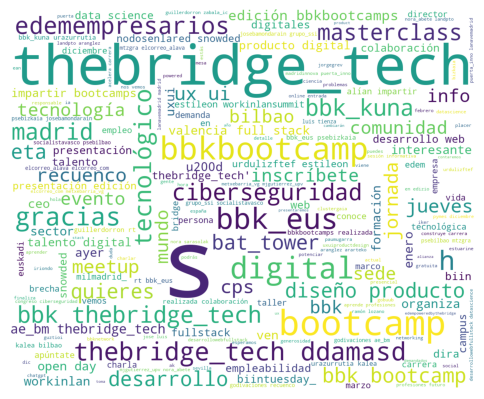

In [115]:
plt.subplots(figsize=(6,6))
wordcloud = WordCloud(background_color='white',width=1200,height=980).generate(str(df_unido["text"].values))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Sobresale por encima de todo The_bridge_tech, ya que obviamente estan en todos los tweets, pero sobretodo palabras como digital, bootcamp y bbk_bootcamp destacan.

e. ¿Qué correlaciones encuentras en tus datos?

Primero vemos que columnas numéricas nos pueden importar en nuestro analisis

In [116]:
df_unido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   author_id               149 non-null    object             
 1   created_at              149 non-null    datetime64[ns, UTC]
 2   edit_history_tweet_ids  149 non-null    object             
 3   id                      149 non-null    object             
 4   public_metrics          149 non-null    object             
 5   text                    149 non-null    object             
 6   impression_count        149 non-null    int64              
 7   like_count              149 non-null    int64              
 8   quote_count             149 non-null    int64              
 9   reply_count             149 non-null    int64              
 10  retweet_count           149 non-null    int64              
 11  dia                     149 non-null    int32

In [117]:
df_unido["impression_count"]

0      113
1      124
2       49
3      218
4      120
      ... 
144    166
145     51
146     82
147    116
148    593
Name: impression_count, Length: 149, dtype: int64

In [118]:
# Creamos otro data frame para analizar los datos de correlacion
df_corr = df_unido[["impression_count","like_count","quote_count","reply_count","retweet_count","dia","mes","año"]].copy()

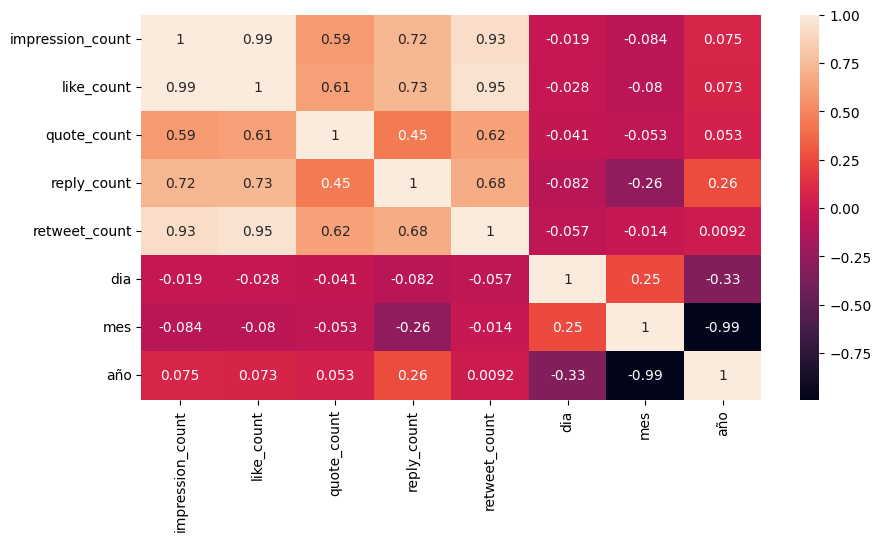

In [119]:
plt.figure(figsize=(10,5))
sns.heatmap(df_corr.corr(),annot=True);

En cuanto al dia, mes y año, como tenemos solo datos de 4 meses tampoco podemos hacer una valoración de ellos, pero si de las demás variables.

Lo que se ve es que las correlaciones entre las diferentes variables son positivas.  

Que practicamente hay un 0.50% de posibilidades de responder a una etiqueta puesta por otra persona.  

También otra cosa a tener en cuenta es que a mayor numero de retweets, mayor numero de likes y de impresiones,lo cual es bueno.

In [120]:
df_unido.to_csv("../data/df_limpio.csv")

[Volver al índice](#0)

<a id="4"></a> <br>
### 4. Machine Learning 

a. ¿De qué tipo de modelo se trata?

In [121]:
df_unido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   author_id               149 non-null    object             
 1   created_at              149 non-null    datetime64[ns, UTC]
 2   edit_history_tweet_ids  149 non-null    object             
 3   id                      149 non-null    object             
 4   public_metrics          149 non-null    object             
 5   text                    149 non-null    object             
 6   impression_count        149 non-null    int64              
 7   like_count              149 non-null    int64              
 8   quote_count             149 non-null    int64              
 9   reply_count             149 non-null    int64              
 10  retweet_count           149 non-null    int64              
 11  dia                     149 non-null    int32

In [122]:
with open('../model/finished_model', "rb") as archivo_entrada:
    model_trained = pickle.load(archivo_entrada)

c:\Users\usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.0.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpic

[Volver al índice](#0)

In [124]:
model_trained

Pipeline(steps=[('vect',
                 CountVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('cls', LogisticRegression(max_iter=10000))])

Es un pipeline con un countvectorizer junto con una regresión logistica.

b. ¿Cuáles son las predicciones? Interpreta los resultados

In [125]:
predictions = model_trained.predict(df_unido['text'])
df_unido['sentiment'] = pd.DataFrame(predictions)

In [126]:
df_unido.head()

,author_id,created_at,edit_history_tweet_ids,id,public_metrics,text,impression_count,like_count,quote_count,reply_count,retweet_count,dia,mes,año,sentiment
0,1151510939105144834,2022-12-29 16:39:19+00:00,[1608502937332113408],1608502937332113408,"{'impression_count': 113, 'like_count': 4, 'qu...",empieza año formándote profesiones 𝗱𝗲𝗺𝗮𝗻𝗱𝗮 𝗹𝗮𝗯...,113,4,0,0,1,29,12,2022,0
1,570795448,2022-12-29 12:52:11+00:00,[1608445776732246017],1608445776732246017,"{'impression_count': 124, 'like_count': 2, 'qu...",bootcamps tecnológicos edem thebridge_tech emp...,124,2,0,0,0,29,12,2022,0
2,1128860148,2022-12-29 09:16:11+00:00,[1608391421014196224],1608391421014196224,"{'impression_count': 49, 'like_count': 2, 'quo...",edemempresarios acoge enero open day participa...,49,2,0,0,0,29,12,2022,0
3,570795448,2022-12-27 09:00:57+00:00,[1607662809575292929],1607662809575292929,"{'impression_count': 218, 'like_count': 5, 'qu...",estás buscando profesión cambie vida acércate ...,218,5,0,0,0,27,12,2022,0
4,1162694149956603904,2022-12-23 12:54:06+00:00,[1606271930763354112],1606271930763354112,"{'impression_count': 120, 'like_count': 1, 'qu...",thebridge_tech deseo ti💫 ¡qué venga cargado éx...,120,1,0,0,1,23,12,2022,0


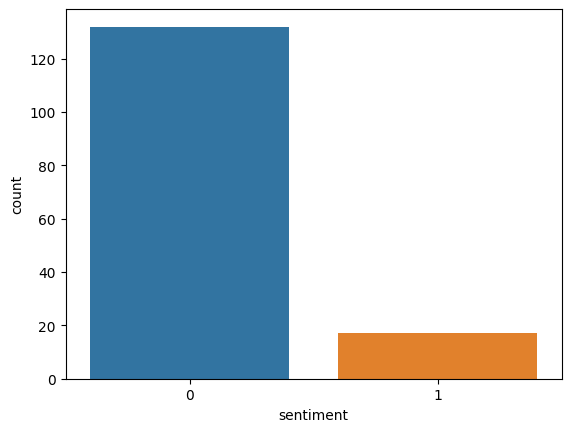

In [127]:
sns.countplot(df_unido, x='sentiment');

En este caso 0 es un buen sentimiento y 1 es un sentimiento negativo

c. ¿Cómo podrías mejorar el modelo?

In [128]:
df_unido["text"]

0      empieza año formándote profesiones 𝗱𝗲𝗺𝗮𝗻𝗱𝗮 𝗹𝗮𝗯...
1      bootcamps tecnológicos edem thebridge_tech emp...
2      edemempresarios acoge enero open day participa...
3      estás buscando profesión cambie vida acércate ...
4      thebridge_tech deseo ti💫 ¡qué venga cargado éx...
                             ...                        
144    🚀 edemempresarios thebridge_tech alían imparti...
145    gracias amigos thebridge_tech acogernos 🙏 s///...
146    interesa diseño #producto digital ven #masterc...
147    ¡empezamos año #masterclass #uxui introducción...
148    🤝 edemempresarios alía thebridge_tech impartir...
Name: text, Length: 149, dtype: object

Para mejorar el modelo utilizaria un TfidfVectorizer

In [137]:
X_train, X_test, y_train, y_test = train_test_split(df_unido['text'], df_unido['sentiment'], test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

classifier = LogisticRegression(max_iter=10000)

classifier.fit(X_train_tfidf, y_train)

y_pred = classifier.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy de: {accuracy:.2f}")

Accuracy de: 0.90


d. ¿Qué otras oportunidades se te ocurren donde se podrían aplicar otros
modelos de ML?

Podriamos intentar a meter un pipeline de un TfidfVectorizer con un random forest.

In [145]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('rf', RandomForestClassifier(n_estimators=100))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy de: {accuracy:.2f}")

Accuracy de: 0.93


Podriamos mejorar un poco el modelo pero tendriamos que tener en cuenta los hiperparametros para ver si estamos en overfitting o no.

<a id="5"></a> <br>
### 5. Conclusiones finales.

Ademas de otros modelos de predicción diferentes a Countvectorizer y una logisticregression que son modelos sencillos para procesamiento de palabras, utilizaría mejor TfidfVectorizer ya que penaliza las palabras que tienen demasiada frecuencia dando más peso a otras que no tienen tanta y así tener una mejor visión del problema.

[Volver al índice](#0)